In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1.1 Simulate 5 realizations

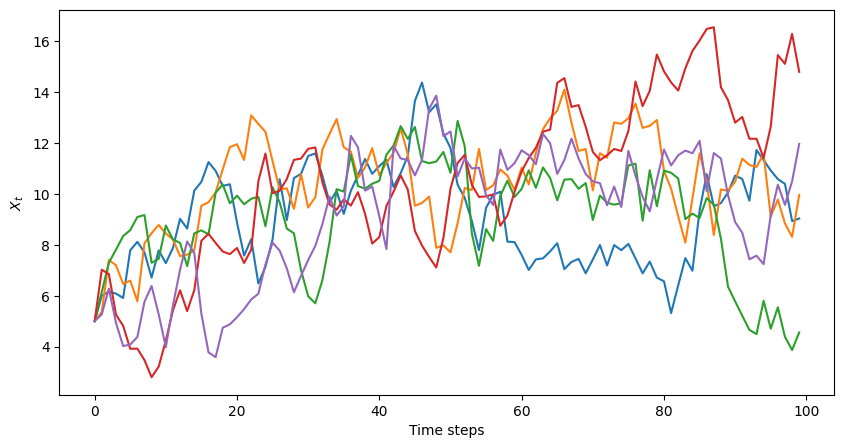

In [21]:
np.random.seed(42)
# Parameters
a = 0.9
b = 1
sigma1 = 1
X0 = 5
n = 100
num_realizations = 5

X = np.zeros((num_realizations, n))
X[:, 0] = X0

# Simulate the process
for t in range(1, n):
    noise = np.random.normal(0, sigma1, size=num_realizations)
    X[:, t] = a * X[:, t - 1] + b + noise

plt.figure(figsize=(10,5))
plt.plot(X.T)
plt.xlabel('Time steps')
plt.ylabel('$X_t$')
plt.show()

# 1.2 Simulate a single realization with observation noise

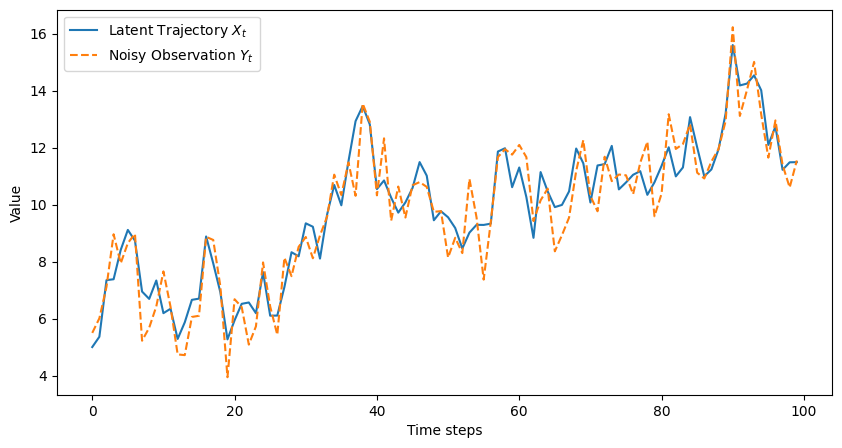

In [31]:
np.random.seed(42)
# Parameters
a = 0.9
b = 1
sigma1 = 1
X0 = 5
n = 100
num_realizations = 1

X = np.zeros((num_realizations, n))
X[:, 0] = X0
Y = np.zeros((num_realizations, n))
Y[:, 0] = X0 + np.random.normal(0, 1, size = num_realizations)

# Simulate the process
for t in range(1, n):
    noise = np.random.normal(0, sigma1, size=num_realizations)
    X[:, t] = a * X[:, t - 1] + b + noise
    obs_noise = np.random.normal(0, 1, size = num_realizations)
    Y[:, t] = X[:, t] + obs_noise

plt.figure(figsize=(10,5))
plt.plot(X.T, label = "Latent Trajectory $X_t$")
plt.plot(Y.T, label = "Noisy Observation $Y_t$", linestyle="--")
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.show()

# 1.3 Kalman filtering

In [ ]:
def myKalmanFilter(y, theta, R, X0, P0):
    """
    Kalman filter for 1D state-space model:
        X_t+1 = a * X_t + b + ε1_t,   ε1_t ~ N(0, Q)
        Y_t = X_t + ε2_t,             ε2_t ~ N(0, R)

    Inputs:
    - y: array of observations (length T)
    - theta: tuple (a, b, Q) of system parameters
    - R: observation noise variance
    - X0: initial state estimate
    - P0: initial estimate variance

    Returns:
    - X_pred: predicted state means (length T)
    - P_pred: predicted state variances
    - innovations: Y_t - predicted Y_t
    - S: innovation variances
    - X_filt: filtered state means (posterior)
    - P_filt: filtered state variances (posterior)
    """
    a, b, Q = theta
    T = len(y)
    
    # Pre-allocate arrays
    X_pred = np.zeros(T)
    P_pred = np.zeros(T)
    innovations = np.zeros(T)
    S = np.zeros(T)
    X_filt = np.zeros(T)
    P_filt = np.zeros(T)
    
    # Initial values
    X_prev = X0
    P_prev = P0
    
    for t in range(T):
        # === Predict step ===
        X_pred[t] = a * X_prev + b
        P_pred[t] = a**2 * P_prev + Q
        
        # === Update step ===
        innovations[t] = y[t] - X_pred[t]         # Innovation: y_t - C * X_pred (C=1)
        S[t] = P_pred[t] + R                      # Innovation variance: C * P_pred * C^T + R (C=1)

        K = P_pred[t] / S[t]                      # Kalman gain

        X_filt[t] = X_pred[t] + K * innovations[t]   # Updated state estimate
        P_filt[t] = (1 - K) * P_pred[t]              # Updated estimate variance

        # Prepare for next step
        X_prev = X_filt[t]
        P_prev = P_filt[t]
    
    return X_pred, P_pred, innovations, S, X_filt, P_filt

In [41]:
Y_filtered

(array([ 5.5       ,  5.94809514,  6.38659371,  7.13979077,  8.40400687,
         8.31390261,  8.66177286,  8.96448272,  7.05600479,  6.60917771,
         6.85054375,  7.59815815,  7.20080069,  6.15830524,  5.76753475,
         6.34601722,  6.57796017,  8.15162563,  8.66275315,  7.9725664 ,
         6.00793971,  6.76743868,  6.89385586,  6.23226592,  6.3375276 ,
         7.58143145,  7.20133717,  6.52802137,  7.74062383,  7.83072488,
         8.41638766,  8.81493769,  8.55768279,  8.89482673,  9.37254892,
        10.33719599, 10.30272101, 10.90498428, 10.49371802, 12.08452749,
        12.31681565, 11.01366666, 11.61699241, 10.28211748, 10.44245804,
         9.91549218, 10.33355034, 10.54497149, 10.53189194, 10.05578175,
         9.89678261,  8.96191322,  8.99771226,  8.72106279, 10.02183078,
         9.76423498,  8.49895211,  9.12868139, 10.58142871, 11.254646  ,
        11.39707318, 11.63102083, 11.48581453, 10.22671028, 10.16283609,
        10.36004349,  9.24873089,  9.15030239,  9.4

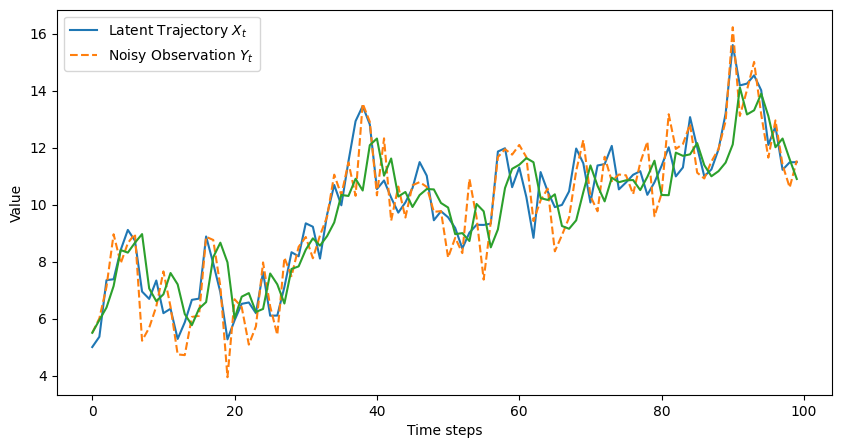

In [44]:
Y_filtered = myKalmanFilter(Y[0], (a, b, sigma1), 1, X0, 1)
plt.figure(figsize=(10,5))
plt.plot(X.T, label = "Latent Trajectory $X_t$")
plt.plot(Y.T, label = "Noisy Observation $Y_t$", linestyle="--")
plt.plot(Y_filtered[0])
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.show()